In [1]:
import time
import os
import glob
import cv2
import numpy as np

from keras.utils import np_utils
from keras.utils import to_categorical

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


<h1>Dataset</h1>

In [2]:
### paths to training and testing data
train_path = 'dataset/train'
test_path = 'dataset'

### other parameters
classes = ["dog", "cat"]
num_classes = len(classes)

### image dimensions
img_width, img_height = 250, 250

In [3]:
def load_images(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height), cv2.INTER_LINEAR)
    return resized

In [4]:
def load_train():
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Loading training images...')
    folders = ["dogs", "cats"]
    for fld in folders:
        index = folders.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = load_images(fl)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(index)

    print('Training data load time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id

In [5]:
def load_test():
    X_test = []
    X_test_id = []
    y_test = []
    start_time = time.time()

    print('Loading test images...')
    folders = ["test"]
    for fld in folders:
        index = folders.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(test_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = load_images(fl)
            X_test.append(img)
            X_test_id.append(flbase)
            y_test.append(index)

    print('Test data load time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_test, y_test, X_test_id

In [6]:
def normalize_train_data():
    train_data, train_target, train_id = load_train()

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)

    train_data = train_data.astype('float32')
    train_data = train_data / 255
    train_target = to_categorical(train_target, num_classes)

    print('Shape of training data:', train_data.shape)
    return train_data, train_target, train_id

In [7]:
def normalize_test_data():
    test_data, test_target, test_id = load_test()

    test_data = np.array(test_data, dtype=np.uint8)
    test_target = np.array(test_target, dtype=np.uint8)

    test_data = test_data.astype('float32')
    test_data = test_data / 255
    test_target = to_categorical(test_target, num_classes)

    print('Shape of testing data:', test_data.shape)
    return test_data, test_target, test_id

In [8]:
x_train, y_train, train_id = normalize_train_data()

Loading training images...
Loading dogs files (Index: 0)
Loading cats files (Index: 1)
Training data load time: 14.33 seconds
Shape of training data: (6000, 250, 250, 3)


In [9]:
x_test, y_test, test_id = normalize_test_data()

Loading test images...
Loading test files (Index: 0)
Test data load time: 2.18 seconds
Shape of testing data: (1000, 250, 250, 3)


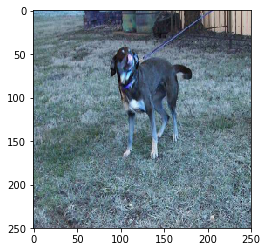

In [10]:
plt.imshow(x_train[0])

<h2>Criando uma CNN</h2>

In [11]:
from keras.layers import *
from keras.models import Model
from keras import optimizers

In [12]:
input_node = Input(shape=(img_width, img_height, 3))

conv_1 = Conv2D(filters=4, kernel_size=(3, 3), strides=1,
                activation='relu')(input_node)
pool_1 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(filters=8, kernel_size=(3, 3), strides=1,
               activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(filters=16, kernel_size=(3, 3), strides=1,
               activation='relu')(pool_2)
conv_4 = Conv2D(filters=32, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_3)

flat = Flatten()(conv_4)

fc1 = Dense(num_classes, activation='softmax')(flat)

model = Model(input_node, fc1)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 4)       112       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 8)       296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 57, 32)        4640      
__________

<h2>Compilando o modelo</h2>

In [14]:
from keras.optimizers import *
from keras.metrics import *

In [15]:
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [16]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(min_delta=1e-3, monitor='val_loss', patience=3)

In [17]:
model.fit(x_train, 
          y_train, 
          batch_size=32, 
          epochs=1,
          callbacks=[early_stop],
          validation_data=(x_test, y_test))

Train on 6000 samples, validate on 1000 samples
Epoch 1/1
6000/6000 [==============================] - 156s 26ms/step - loss: 0.6583 - acc: 0.5992 - val_loss: 0.8628 - val_acc: 0.2990
